In [1]:
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-jfxicyxi
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29722 sha256=55b416868531637615560b928c1d64ccf3e8a1c3254891b2c0a5e967b2a9d6f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-3tc5ddi5/wheels/11/5d/8c/04ffb7a0ca5427f3e674703ea75ecb16542e94efcc46d6bc1b
Successfully built face-detection


In [2]:
import cv2
import tensorflow as tf 
import numpy as np
import random

from sklearn.model_selection import train_test_split

from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import face_detection

import fnmatch, os

In [3]:
WORKING_DIR = "./"
SRC_PATH = "./Data"
DES_PATH = "./TrainingSet"
MODEL_DIR = "./Model"


In [4]:
def extractFrame (desPath, videoPath, label):
  imagesFolder = os.path.join(desPath, label)
  os.mkdir(imagesFolder)

  cap= cv2.VideoCapture(videoPath)
  i=0

  c=1
  while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
      break
    
    if c%12==0:
      i+=1
      cv2.imwrite(os.path.join(imagesFolder, str(i)+'.jpg'),frame)

    c+= 1
    

In [5]:
def extractFace(frame, required_size=(160, 160)):
  
  detector = face_detection.build_detector(
  "DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

  # detect faces in the image
  results = detector.detect(frame)

  # extract the bounding box from the first face
  if len(results) > 0:
    x_min, y_min, x_max, y_max = results[0][:4]
    
    # extract the face
    x_min = max(int(x_min), 0)
    x_max = int(x_max)
    y_min = max(int(y_min), 0)
    y_max = int(y_max)

    face = frame[y_min:y_max, x_min:x_max].copy()
    face = cv2.resize(face, required_size)

    return face

  # i+=1

In [6]:
def loadFaces (folderPath):
  faces = []
  filenames = os.listdir(folderPath)
  for i in tf.range(len(filenames)):
    img = cv2.imread(os.path.join(folderPath,filenames[i]))
    
    face = extractFace(img)
    
    if (face is not None):
		  # store
      # print(filenames[i], face.shape)
      faces.append(face)
  faces = np.array(faces)
  return faces

In [7]:
def loadDataset (path):
  X = []
  Y = []

  desPath = DES_PATH
  os.mkdir(desPath)

  # Extract frames from video
  LABELS = []
  data = fnmatch.filter(os.listdir(path), '*.mp4')
  for file in data:
    label = file[:-4]
    LABELS.append(label)
    extractFrame (desPath, os.path.join(path, file), label)

  # Extract faces from the frame
  for l in LABELS:
    imgPath = os.path.join(desPath, l)
    faces = loadFaces(imgPath)
    labels = [l]*len(faces)

    # print(type(faces))
    X.extend(faces)
    Y.extend(labels)

  X = np.array(X)
  Y = np.array(Y) 
  # print(X.shape)
  return X, Y

In [ ]:
# import shutil
# shutil.rmtree(DES_PATH)

In [8]:
X_train, Y_train = loadDataset(SRC_PATH)

Downloading: "http://folk.ntnu.no/haakohu/WIDERFace_DSFD_RES152.pth" to /home/hangduong/.cache/torch/hub/checkpoints/WIDERFace_DSFD_RES152.pth


In [9]:
print(X_train.shape)
print(Y_train.shape)


(601, 160, 160, 3)
(601,)


In [10]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [11]:
np.savez_compressed(os.path.join(WORKING_DIR, 'faces-dataset.npz'), x_train, x_val, y_train, y_val)

In [12]:
data = np.load(os.path.join(WORKING_DIR, 'faces-dataset.npz'))
x_train, x_val, y_train, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']


In [13]:
# load the model
# https://drive.google.com/file/d/1971Xk5RwedbudGgTIrGAL4F7Aifu7id1/view
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'facenet_keras.h5'))

# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


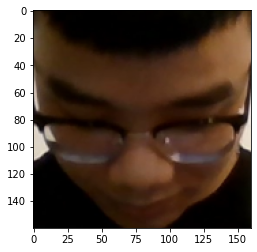

In [25]:
from matplotlib import pyplot

frame = cv2.imread("TrainingSet/Tuấn/27.jpg")
face = extractFace(frame)
pyplot.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

In [14]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
 
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std

	# transform face into one sample
	samples = np.expand_dims(face_pixels, axis=0)
 
	# make prediction to get embedding
	yhat = model.predict(samples)
 
	return yhat[0]

In [15]:
x_em_train = []

for face_pixels in x_train:
	embedding = get_embedding(model, face_pixels)
	x_em_train.append(embedding)
x_em_train = np.array(x_em_train)

print(x_em_train.shape)

# convert each face in the test set to an embedding
x_em_val = []
for face_pixels in x_val:
	embedding = get_embedding(model, face_pixels)
	x_em_val.append(embedding)
x_em_val = np.array(x_em_val)

print(x_em_val.shape)

(480, 128)
(121, 128)


In [16]:
# save arrays to one file in compressed format
np.savez_compressed(os.path.join(WORKING_DIR,'faces-embeddings.npz'), x_em_train, x_em_val, y_train, y_val)

In [17]:
data = np.load(os.path.join(WORKING_DIR,"faces-embeddings.npz"))
x_em_train, x_em_val, y_train, y_val = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [19]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(x_em_train)
valX = in_encoder.transform(x_em_val)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
trainY = out_encoder.transform(y_train)
valY = out_encoder.transform(y_val)

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainY)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(valX)

# score
score_train = accuracy_score(trainY, yhat_train)
score_test = accuracy_score(valY, yhat_test)

# summarize
print('Accuracy: train=%.3f, val=%.3f' % (score_train*100, score_test*100))



Accuracy: train=98.542, val=96.694


In [20]:
yhat_class =model.predict(x_em_val)
yhat_prob = model.predict_proba(x_em_val)
for i in range(len(x_em_val)):
  classIdx = yhat_class[i]
  classProb = yhat_prob[i, classIdx] * 100

  predictNames = out_encoder.inverse_transform(yhat_class)
  print('Predicted: %s (%.3f)' % (predictNames[i], classProb))
  print('Expected: %s' % y_val[i])

Predicted: Hùng (100.000)
Expected: Hùng
Predicted: Hiếu (100.000)
Expected: Hiếu
Predicted: Kiên (100.000)
Expected: Kiên
Predicted: Hùng (100.000)
Expected: Hùng
Predicted: Tuấn (100.000)
Expected: Tuấn
Predicted: Linh (100.000)
Expected: Linh
Predicted: Trường (100.000)
Expected: Trường
Predicted: Quân (100.000)
Expected: Quân
Predicted: Hùng (100.000)
Expected: Hùng
Predicted: Việt Đức (100.000)
Expected: Việt Đức
Predicted: Vân (100.000)
Expected: Vân
Predicted: Hùng (100.000)
Expected: Hùng
Predicted: Hùng (100.000)
Expected: Hùng
Predicted: Thắng (100.000)
Expected: Thắng
Predicted: Việt Đức (99.638)
Expected: Việt Đức
Predicted: Xuân Anh (100.000)
Expected: Xuân Anh
Predicted: Trường (100.000)
Expected: Trường
Predicted: Xuân Anh (100.000)
Expected: Xuân Anh
Predicted: Tuấn (92.994)
Expected: Tuấn
Predicted: Hùng (100.000)
Expected: Hùng
Predicted: Trường (100.000)
Expected: Trường
Predicted: Thắng (100.000)
Expected: Thắng
Predicted: Việt Đức (96.911)
Expected: Kiên
Predicted: